In [109]:
import pandas as pd
import numpy as np
import os
from os.path import isfile, join
import matplotlib.pyplot as plt

import trPL_importClass

/home/qrb/Documents/PhD/Scripts/TRPL_dataAnalysis/Development-trPLtrSPV/trPL_Analysis/trPL_importClass.py:492: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel("Time [$\mu$s]", fontsize=axis_fontsize)
/home/qrb/Documents/PhD/Scripts/TRPL_dataAnalysis/Development-trPLtrSPV/trPL_Analysis/trPL_importClass.py:497: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel("Time [$\mu$s]", fontsize=axis_fontsize)
/home/qrb/Documents/PhD/Scripts/TRPL_dataAnalysis/Development-trPLtrSPV/trPL_Analysis/trPL_importClass.py:550: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel("Time [$\mu$s]", fontsize=axis_fontsize)


In [3]:
TRPL_folderpath = '/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 TRPL Maxim/BS'

In [4]:
os.listdir(TRPL_folderpath)

['M02t16-BS_3826-43000ns_300nsGate.asc',
 'M02t16-BS_80p3-835ns_2p5nsGate_dark.sif',
 'M02t16_24000-85700ns_2500nsGate_dark.asc',
 'M02t16-BS_638-5583ns_20nsGate.asc',
 'M02t16-BS_11p0-115ns_1p9nsGate_dark.asc',
 'M02t16-BS_80p3-835ns_2p5nsGate_dark.asc',
 'M02t16_3826-43000ns_300nsGate_dark.asc',
 'M02t16-BS_24000-85700ns_2500nsGate.asc',
 'M02t16-BS_11p0-115ns_1p9nsGate.sif',
 'M02t16-BS_638-5583ns_20nsGate_dark.sif',
 'M02t16-BS_80p3-835ns_2p5nsGate.asc',
 'M02t16-BS_24000-85700ns_2500nsGate.sif',
 'M02t16-BS_80p3-835ns_2p5nsGate.sif',
 'M02t16-BS_11p0-115ns_1p9nsGate_dark.sif',
 'M02t16-BS_638-5583ns_20nsGate_dark.asc',
 'M02t16-BS_3826-43000ns_300nsGate.sif',
 'M02t16-BS_638-5583ns_20nsGate.sif',
 'M02t16-BS_11p0-115ns_1p9nsGate.asc']

In [5]:
files = [f for f in os.listdir(TRPL_folderpath) if (isfile(join(TRPL_folderpath, f)) and f.endswith(".asc") and not (f.endswith("dark.asc")))]
files = np.array(files)
print(files)
delay0s = np.zeros((len(files),))
for i, f in enumerate(files):
    delay0s[i] = (float(f.split("_")[1].split("-")[0].replace("p", ".")))
inds = delay0s.argsort()
delay0s = delay0s[inds]
files = files[inds]

['M02t16-BS_3826-43000ns_300nsGate.asc'
 'M02t16-BS_638-5583ns_20nsGate.asc'
 'M02t16-BS_24000-85700ns_2500nsGate.asc'
 'M02t16-BS_80p3-835ns_2p5nsGate.asc' 'M02t16-BS_11p0-115ns_1p9nsGate.asc']


In [98]:
class trPL_withSpectra:
    def __init__(self, TRPL_folderpath, SPV_folderpath):
        self.TRPL_folderpath = TRPL_folderpath
        self.TRPL_spcts_folder_read()
        self.generateData()
        self.stitch_trPL()
    
    def TRPL_spcts_folder_read(self):
        files = [f for f in os.listdir(self.TRPL_folderpath) if (isfile(join(self.TRPL_folderpath, f)) and f.endswith(".asc") and not(f.endswith("dark.asc")))]
        files = np.array(files)
        
        delay0s = np.zeros((len(files),))
        for i, f in enumerate(files):
            delay0s[i] = (float(f.split("_")[1].split("-")[0].replace("p", ".")))
        inds = delay0s.argsort()
        self.delay0s = delay0s[inds]
        self.files = files[inds]
    

        files_dark = [f for f in os.listdir(self.TRPL_folderpath) if (isfile(join(self.TRPL_folderpath, f)) and f.endswith("dark.asc"))]
        files_dark = np.array(files_dark)
        delay0s_dark = np.zeros((len(files),))
        for i, f in enumerate(files_dark):
            delay0s_dark[i] = (float(f.split("_")[1].split("-")[0].replace("p", ".")))
        inds = delay0s_dark.argsort()
        self.delay0s_dark = delay0s_dark[inds]
        self.files_dark = files_dark[inds]

    def generateData(self):
        
        preamble_dfs = []
        step_list = []
        trPLs_integral = []
        spectraCounts_list = []
        spectraWLs_list = []
        for i, f in enumerate(self.files):
            print("File", f)
            print("--- Dark", self.files_dark[i])
            # Measurement Meta-Data
            df_preamble = pd.read_csv(join(self.TRPL_folderpath, f), nrows=36, header=None, dtype=str, delimiter = '\t')
            preamble_dfs.append(df_preamble)
            time_step = 1e-12*float(df_preamble.iloc[32][0].split()[-1].split('exp')[0]) #s
            exp_factor = float(df_preamble.iloc[32][0].split()[-1].split('exp')[1][1:-2])
            gate_delay0 = 1e-9*float(df_preamble.iloc[31][0].split()[-1]) #ns
            len_series = int(df_preamble.iloc[9][0].split()[-1])

            # trPL Data
            df2 = pd.read_csv(join(self.TRPL_folderpath, f), header=36, delimiter = '\t', names=['lambdas', 'acc-counts'],  index_col=False)
            ls = df2['lambdas'].to_numpy()
            counts = df2['acc-counts'].to_numpy()
            diff = ls[1:]-ls[:-1]
            len_ls = np.argwhere(diff < 0)[0][0]+1
            #background
            bg = pd.read_csv(join(self.TRPL_folderpath, self.files_dark[i]), header=33, delimiter = '\t', names=['lambdas', 'acc-counts'],  index_col=False)

            trPL = np.zeros((len_series,))
            spectraCounts_denoised = np.zeros((len_series,len_ls))
            spectraWLs = np.zeros((len_series,len_ls))
            step_id = np.arange(len_series)
            steps = np.zeros_like(step_id, dtype=float)
            for j in step_id:
                if not(j):
                    steps[j] = gate_delay0
                else:
                    #print(steps[j-2] +  time_step*np.exp(exp_factor*i))
                    steps[j] = steps[j-1] +  time_step*np.exp(exp_factor*j)
                    
                trPL[j] = np.trapezoid(counts[j*len_ls:(j+1)*len_ls] - bg['acc-counts'], x = ls[j*len_ls:(j+1)*len_ls])
                spectraCounts_denoised[j, :] = counts[j*len_ls:(j+1)*len_ls] - bg['acc-counts']
                spectraWLs[j, :] = ls[j*len_ls:(j+1)*len_ls]
                plt.plot(ls[j*len_ls:(j+1)*len_ls], bg['acc-counts'])
                #plt.plot(ls[i*len_ls:(i+1)*len_ls], counts[i*len_ls:(i+1)*len_ls])

            trPLs_integral.append(trPL)
            step_list.append(steps)
            spectraCounts_list.append(spectraCounts_denoised)
            spectraWLs_list.append(spectraWLs)

        self.trPLs_integral = trPLs_integral
        self.step_list = step_list
        self.spectraCounts_list = spectraCounts_list
        self.spectraWLs_list = spectraWLs_list

    def stitch_trPL(self):
        
        stitch_t = np.array([])
        stitch_trPL = np.array([])
        
        #stitch_spectra = np.array([])
        scale = 1
        for i, (t, trPL) in enumerate(zip(self.step_list, self.trPLs_integral)):
            stitch_t = np.concatenate((stitch_t, t))
            if i:
                arg = np.argmin(np.abs(self.step_list[i-1] - t[0]))
                print(arg)
                scale = scale*self.trPLs_integral[i-1][arg]/np.amax(self.trPLs_integral[i-1])
            stitch_trPL = np.concatenate((stitch_trPL, scale*trPL/np.amax(trPL)))

        self.stitch_t = stitch_t
        self.stitch_trPL = stitch_trPL

        #Get the change in center of mass in function of time
        hc = 1.24e-6
        for i, (wls, spcts) in enumerate(zip(self.spectraWLs_list, self.spectraCounts_list)):
            if not(i):
                max_E = np.zeros((len(wls),))

                integral_L = np.zeros((len(wls),))
                integral_R = np.zeros((len(wls),))

                CoM = np.zeros((len(wls),))

                for j, (wl, spct) in enumerate(zip(wls, spcts)):
                    
                    E = 1240/wl
                    max_E[j] = E[np.argmax((hc/E**2)*spct)]

                    select_L = (E > 1.45) & (E<1.52)
                    integral_L[j] = np.trapezoid((hc/E[select_L]**2)*spct[select_L], x = E[select_L])
                    select_R = (E > 1.57) & (E<1.64) #same size
                    integral_R[j] = np.trapezoid((hc/E[select_R]**2)*spct[select_R], x = E[select_R])

                    select_CoM = (E > 1.45) & (E < 1.8)
                    CoM[j] = np.trapezoid(E[select_CoM]*(hc/E[select_CoM]**2)*spct[select_CoM], x = E[select_CoM]) / np.trapezoid((hc/E[select_CoM]**2)*spct[select_CoM], x = E[select_CoM])

                #     if not(j%5):
                #         plt.plot(E, (hc/E**2)*spct)
                # plt.yscale("log")
                # plt.show()

            else:
                for j, (wl, spct) in enumerate(zip(wls, spcts)):
                    E = 1240/wl
                    select_L = (E > 1.45) & (E<1.52)
                    select_R = (E > 1.57) & (E<1.64) #same size
                    max_E = np.append(max_E, E[np.argmax((hc/E**2)*spct)])
                    integral_L = np.append(integral_L, np.trapezoid((hc/E[select_L]**2)*spct[select_L], x = E[select_L]))
                    integral_R = np.append(integral_R, np.trapezoid((hc/E[select_R]**2)*spct[select_R], x = E[select_R]))

                    select_CoM = (E > 1.45) & (E < 1.8)
                    CoM = np.append(CoM, np.trapezoid(E[select_CoM]*(hc/E[select_CoM]**2)*spct[select_CoM], x = E[select_CoM])/np.trapezoid((hc/E[select_CoM]**2)*spct[select_CoM], x = E[select_CoM]))
                    # if not(j%5):
                    #     plt.plot(E, (hc/E**2)*spct)
                # plt.yscale("log")
                # plt.show()

        self.ratioLoverR_spectras = integral_L/integral_R
        self.CoM_spectras = CoM
        

In [138]:
SPV_folderpath = "/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 trSPV Maxim/All/FS"

files = [f for f in os.listdir(SPV_folderpath) if (isfile(join(SPV_folderpath, f)) and f.endswith("txt") and f.startswith("C3"))]
measurementPos = np.zeros((len(files),))
for i, f in enumerate(files):
    a = 100*float((f.split("_")[0].split("-")[-1][3:4]))
    b = 0
    if ((f.split("_")[0].split("-")[-1][0:2]) == 'EO'):
        b = 50
    c = 0
    if ((f.split("_")[0].split("-")[-2]) == 'Long'):
        c =10
    print((f.split("_")[0].split("-")[-1]), a+b+c)

    measurementPos[i] = a+b+c

inds = measurementPos.argsort()
files = np.array(files)
files  = files[inds]

EOM0 50.0
EOM5 550.0
EOM3 360.0
SOM1 110.0
EOM4 450.0
EOM0 60.0
SOM2 200.0
EOM3 350.0
SOM0 10.0
EOM4 460.0
EOM6 650.0
SOM2 210.0
EOM5 560.0
SOM1 100.0
SOM0 0.0
EOM6 660.0


In [139]:
files[0]

np.str_('C3--M02t16-FS-Short-SOM0_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00000.txt')

In [ ]:
filepath = join(SPV_folderpath, files[0])

spv = pd.read_csv(filepath, skiprows=3, sep = ",", comment='#')
spv

,Time,Ampl
0,-0.000012,0.003749
1,-0.000012,0.003753
2,-0.000012,0.003754
3,-0.000012,0.003754
4,-0.000012,0.003751
...,...,...
999997,0.000488,0.003252
999998,0.000488,0.003251
999999,0.000488,0.003253
1000000,0.000488,0.003259


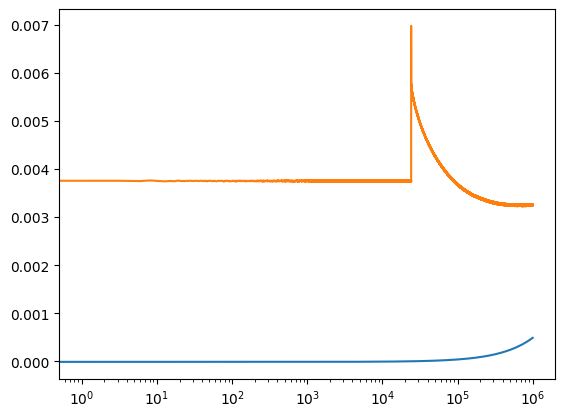

In [145]:
plt.semilogx(spv)

In [111]:
SPVs = trPL_importClass.trPL_measurement_series(r"/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 trSPV Maxim/All/FS", BG = 1.55, thickness = 450e-9, TRPL_denoise = -50, mode = "HySprint", 
                                                    retime = False, importPL=False, importSPV=True, setup  = "wannsee")

TypeError: trPL_measurement_series.__init__() got an unexpected keyword argument 'setup'

File M02t16_11p0-115ns_1p9nsGate.asc
--- Dark M02t16_11p0-115ns_1p9nsGate_dark.asc
File M02t16_80p3-835ns_2p5nsGate_nextDay.asc
--- Dark M02t16_80p3-835ns_2p5nsGate(copy)_dark.asc
File M02t16_80p3-835ns_2p5nsGate.asc
--- Dark M02t16_80p3-835ns_2p5nsGate_dark.asc
File M02t16_638-5191ns_20nsGate.asc
--- Dark M02t16_638-5191ns_20nsGate_dark.asc
File M02t16_3826-43000ns_300nsGate.asc
--- Dark M02t16_3826-43000ns_300nsGate_dark.asc
File M02t16_24000-85700ns_2500nsGate.asc
--- Dark M02t16_24000-85700ns_2500nsGate_dark.asc
71
0
44
29
21


array(['M02t16_11p0-115ns_1p9nsGate.asc',
       'M02t16_80p3-835ns_2p5nsGate_nextDay.asc',
       'M02t16_80p3-835ns_2p5nsGate.asc',
       'M02t16_638-5191ns_20nsGate.asc',
       'M02t16_3826-43000ns_300nsGate.asc',
       'M02t16_24000-85700ns_2500nsGate.asc'], dtype='<U39')

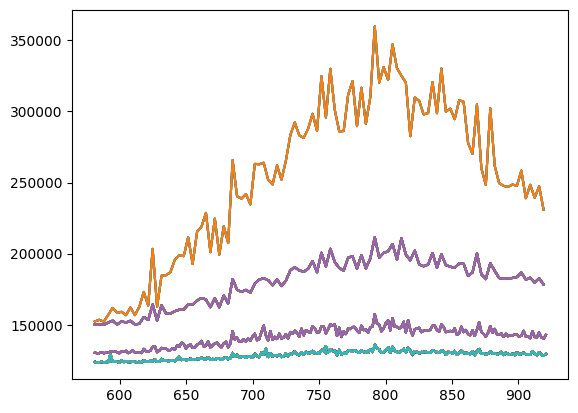

In [99]:
TRPL_folderpath = "/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 TRPL Maxim/FS"
trPLs = trPL_withSpectra(TRPL_folderpath)
trPLs.files

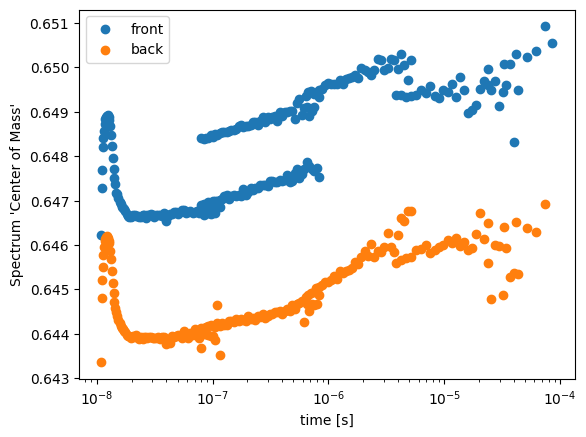

In [107]:
plt.scatter(trPLs.stitch_t, 1/trPLs.CoM_spectras, label = "front")
plt.scatter(trPLs_BS.stitch_t, 1/trPLs_BS.CoM_spectras, label = "back")
plt.xscale("log")
plt.ylabel("Spectrum 'Center of Mass'")
plt.xlabel("time [s]")
plt.legend()

Text(0.5, 0, 'time [s]')

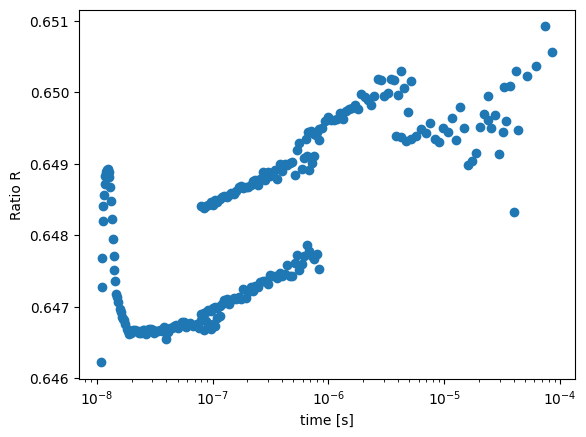

In [94]:
#plt.scatter(trPLs.stitch_t, integral_L/integral_R)
plt.scatter(trPLs.stitch_t, 1/CoM)
plt.xscale("log")
plt.ylabel("Ratio R")
plt.xlabel("time [s]")

File M02t16-BS_11p0-115ns_1p9nsGate.asc
--- Dark M02t16-BS_11p0-115ns_1p9nsGate_dark.asc
File M02t16-BS_80p3-835ns_2p5nsGate.asc
--- Dark M02t16-BS_80p3-835ns_2p5nsGate_dark.asc
File M02t16-BS_638-5583ns_20nsGate.asc
--- Dark M02t16-BS_638-5583ns_20nsGate_dark.asc
File M02t16-BS_3826-43000ns_300nsGate.asc
--- Dark M02t16_3826-43000ns_300nsGate_dark.asc
File M02t16-BS_24000-85700ns_2500nsGate.asc
--- Dark M02t16_24000-85700ns_2500nsGate_dark.asc
71
44
29
21


array(['M02t16-BS_11p0-115ns_1p9nsGate.asc',
       'M02t16-BS_80p3-835ns_2p5nsGate.asc',
       'M02t16-BS_638-5583ns_20nsGate.asc',
       'M02t16-BS_3826-43000ns_300nsGate.asc',
       'M02t16-BS_24000-85700ns_2500nsGate.asc'], dtype='<U38')

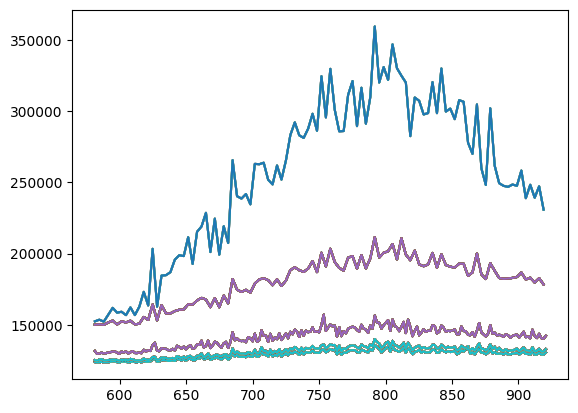

In [100]:
TRPL_folderpath_back = "/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 TRPL Maxim/BS"
trPLs_BS = trPL_withSpectra(TRPL_folderpath_back)
trPLs_BS.files

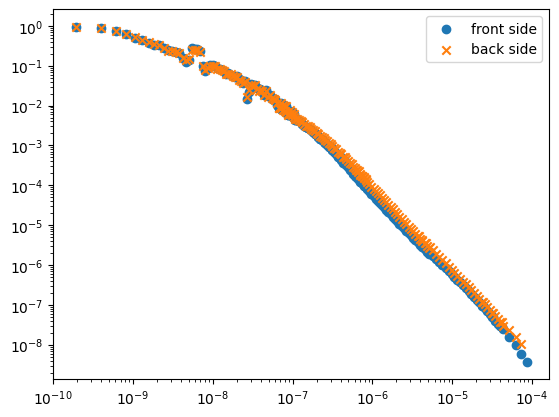

In [10]:
plt.scatter(trPLs.stitch_t - trPLs.stitch_t[np.argmax(trPLs.stitch_trPL)], trPLs.stitch_trPL, label = "front side")
plt.scatter(trPLs_BS.stitch_t - trPLs_BS.stitch_t[np.argmax(trPLs_BS.stitch_trPL)], trPLs_BS.stitch_trPL, label = "back side", marker = "x")
plt.yscale("log")
plt.xscale("log")
plt.legend()